In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [8]:
# CSVファイルからデータを読み込む
def read_data_from_csv(filename):
    data = pd.read_csv(filename)
    return data


# 角速度を計算する（各コンポーネントごと）
def calculate_angular_velocity_component(
    data,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    gyro_x = data["gyro_x"]
    gyro_y = data["gyro_y"]
    gyro_z = data["gyro_z"]
    time = data["time"]
    angular_velocity_x = pd.DataFrame(
        {"time": time, "angular_velocity_x": np.sqrt(np.square(gyro_x))}
    )
    angular_velocity_y = pd.DataFrame(
        {"time": time, "angular_velocity_y": np.sqrt(np.square(gyro_y))}
    )
    angular_velocity_z = pd.DataFrame(
        {"time": time, "angular_velocity_z": np.sqrt(np.square(gyro_z))}
    )
    return angular_velocity_x, angular_velocity_y, angular_velocity_z


# 角速度を計算する（合成）
def calculate_angular_velocity_all(data) -> pd.Series:
    gyro_x = data["gyro_x"]
    gyro_y = data["gyro_y"]
    gyro_z = data["gyro_z"]
    time = data["time"]
    angular_velocity = pd.Series(
        {
            "time": time,
            "angular_velocity": np.sqrt(
                np.square(gyro_x) + np.square(gyro_y) + np.square(gyro_z)
            ),
        }
    )
    return angular_velocity


def apply_lowpass_filter(data, cutoff_freq, sampling_freq):
    # バターワースフィルタを設計
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype="low", analog=False)

    # フィルタを適用
    filtered_data = filtfilt(b, a, data["angular_velocity_x"])

    # フィルタ後のデータを pd.DataFrame に変換
    filtered_df = pd.DataFrame(
        {"time": data["time"], "angular_velocity_x": filtered_data}
    )
    return filtered_df


def apply_highpass_filter(data, cutoff_freq, sampling_freq):
    # バターワースフィルタを設計
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(4, normal_cutoff, btype="high", analog=False)

    # フィルタを適用
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def calculate_angle(angular_velocity_df):
    time = angular_velocity_df["time"]
    angular_velocity = angular_velocity_df["angular_velocity"]

    # 角速度を時間間隔ごとに積分して角度を計算する
    angle = np.zeros_like(angular_velocity)
    dt = np.diff(time)  # 時間間隔を計算する

    for i in range(1, len(angular_velocity)):
        # 台形積分を使って角度を計算する
        angle[i] = (
            angle[i - 1]
            + 0.5 * (angular_velocity[i] + angular_velocity[i - 1]) * dt[i - 1]
        )

    # 角度データを pd.DataFrame に変換
    angle_df = pd.DataFrame({"time": time, "angle": angle})

    return angle_df


# データのプロット
def plot_data(raw_data, angular_velocity):
    plt.figure(figsize=(12, 6))

    # ジャイロセンサーデータのプロット
    plt.subplot(2, 1, 1)
    plt.plot(raw_data["time"], raw_data["gyro_x"], label="Gyro X")
    plt.plot(raw_data["time"], raw_data["gyro_y"], label="Gyro Y")
    plt.plot(raw_data["time"], raw_data["gyro_z"], label="Gyro Z")
    plt.title("Gyro Data")
    plt.xlabel("Time [s]")
    plt.ylabel("Gyro [rad/s]")
    plt.legend()

    # 角速度データのプロット
    plt.subplot(2, 1, 2)
    plt.plot(raw_data["time"], angular_velocity, label="Angular Velocity", color="r")
    plt.title("Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_data_angular_velocity(raw_data, angular_velocity):
    plt.figure(figsize=(12, 6))

    # ジャイロセンサーデータのプロット
    plt.subplot(2, 1, 1)
    plt.plot(raw_data["time"], raw_data["angular_velocity_x"], label="Gyro X")
    plt.title("Gyro Data")
    plt.xlabel("Time [s]")
    plt.ylabel("Gyro [rad/s]")
    plt.legend()

    # 角速度データのプロット
    plt.subplot(2, 1, 2)
    plt.plot(
        raw_data["time"],
        angular_velocity["angular_velocity_x"],
        label="Angular Velocity",
        color="r",
    )
    plt.title("Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("Angular Velocity [rad/s]")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_data_angle(raw_data, angle):
    plt.figure(figsize=(12, 6))

    # ジャイロセンサーデータのプロット
    plt.subplot(2, 1, 1)
    plt.plot(raw_data["time"], raw_data["angular_velocity_x"], label="Gyro X")
    plt.title("Gyro Data")
    plt.xlabel("Time [s]")
    plt.ylabel("Gyro [rad/s]")
    plt.legend()

    # 角速度データのプロット
    plt.subplot(2, 1, 2)
    plt.plot(
        raw_data["time"],
        angle["angle_x"],
        label="Angular Velocity",
        color="r",
    )
    plt.title("Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("角度の変化量 [rad/s]")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
filename = "data/02/gyroscope.csv"
cutoff_freq = 2.0
sampling_freq = 60.0

data = read_data_from_csv(filename)
angular_velocity = calculate_angular_velocity_all(data)
angular_velocity_x, angular_velocity_y, angular_velocity_z = (
    calculate_angular_velocity_component(data)
)


filtered_lowpass_angular_velocity_x = apply_lowpass_filter(
    angular_velocity_x, cutoff_freq, sampling_freq
)


angle_x = calculate_angle(filtered_lowpass_angular_velocity_x)

           time  angular_velocity_x
0     10.002003            0.158065
1     10.012003            0.163864
2     10.022003            0.170252
3     10.032003            0.177213
4     10.042003            0.184737
...         ...                 ...
3772  47.722003            0.085995
3773  47.732003            0.083775
3774  47.742003            0.081653
3775  47.752003            0.079651
3776  47.762003            0.077795

[3777 rows x 2 columns]


KeyError: 'angular_velocity'

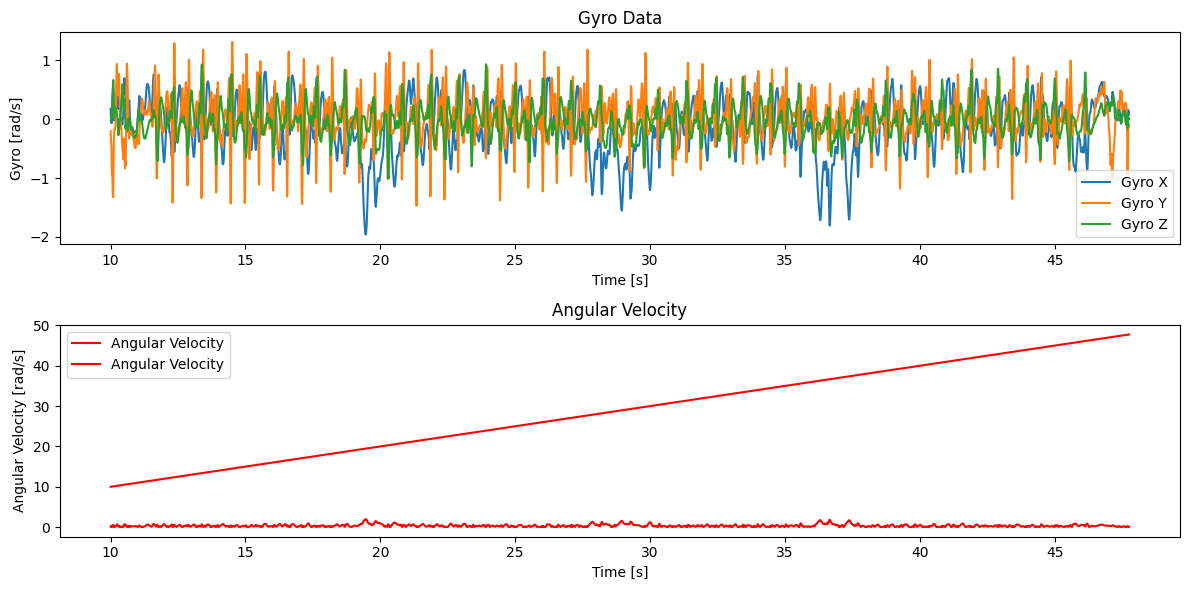

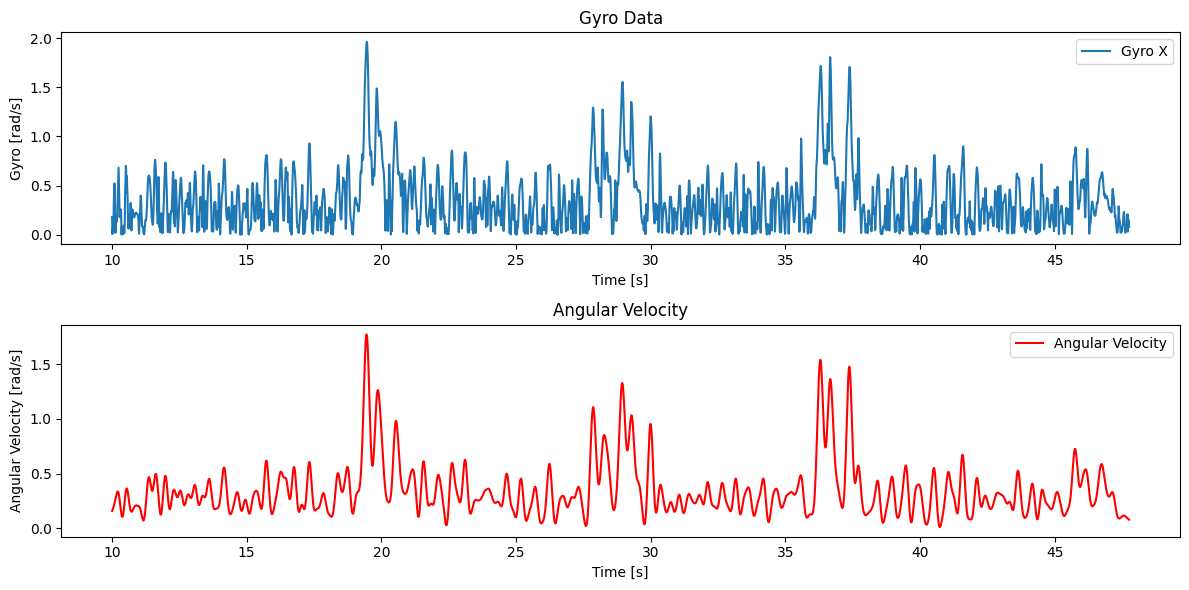

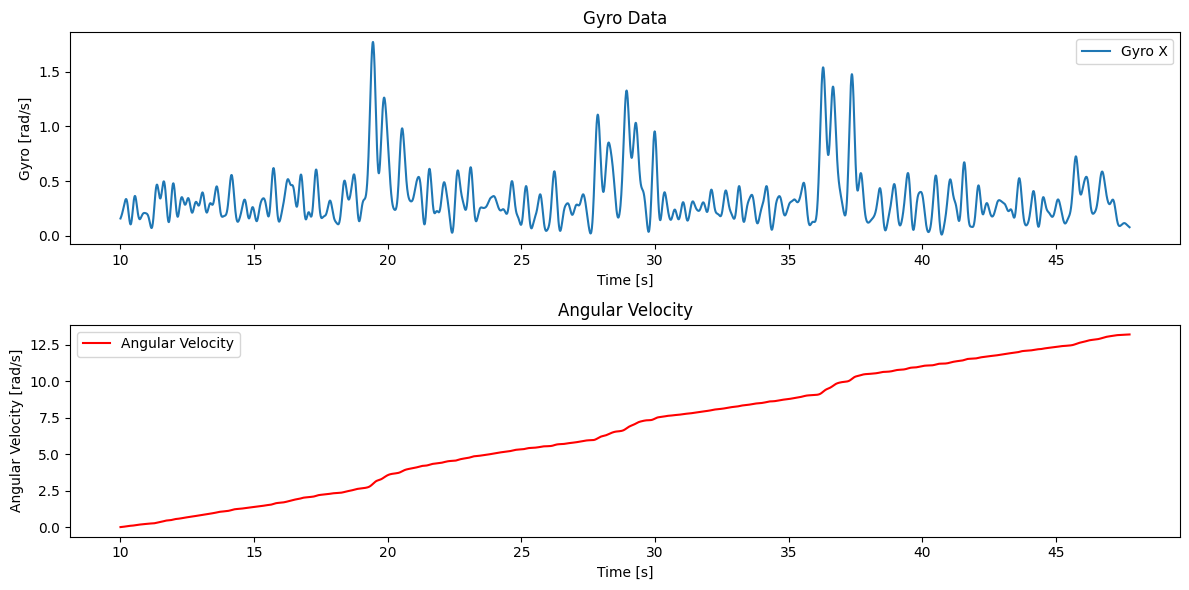

In [ ]:
plot_data(data, angular_velocity_x)
plot_data_angular_velocity(angular_velocity_x, filtered_lowpass_angular_velocity_x)
plot_data_angle(filtered_lowpass_angular_velocity_x, angle_x)